In [1]:
%config InlineBackend.figure_format = "svg"
from tqdm import tqdm
import networkx as nx
import pandas as pd
import numpy as np

# Binary Node Class

In [2]:
class BinaryNode:
    """
    A class for a Bayesian Network node of a boolean random variable
    """
    
    def __init__(self, name):
        self.name = name
        self.parents = []
        self.children = []
        self.pt = None
        
    def add_child(self, name):
        self.children.append(name)
        
    def add_parent(self, name):
        self.parents.append(name)
        
    def add_pt(self, df):
        """
        Adds a probability table to this node
        """
        self.pt = df
        
    def is_root(self):
        return len(self.parents) == 0
    
    def is_leaf(self):
        return len(self.children) == 0
    
    def direct_sample(self, sample):
        """
        Samples this node via the direct sampling algorithm
        given previous acquired samples (of ancester nodes)
        """
        
        # Get the row relative to the current sample where current node is false
        sample = {name: sample[name] for name in sample if name in self.parents}
        df = self.pt
        for name in sample:
            df = df.loc[df[name] == sample[name]]
        df = df.loc[df[self.name] == 0]
        
        # Generate random number
        number = np.random.uniform()
        r = int(np.random.uniform() > df["Prob"])
        
        return r

# Bayesian Network Class

In [3]:
class BayesianNetwork:
    def __init__(self):
        self.graph = {}
        self.nodes = []
        self.edges = []
        
    def draw(self):
        G = nx.DiGraph(directed=True)
        G.add_edges_from(self.edges)
        options = {
            'node_color': 'orange',
            'node_size': 3000,
            'width': 3,
            'arrowstyle': '-|>',
            'arrowsize': 12,
        }
        nx.draw_networkx(G, arrows=True, **options)
        
    def add_node(self, name):
        if name not in self.graph:
            self.graph[name] = BinaryNode(name)
            self.nodes.append(name)
            
    def add_nodes(self, names):
        for name in names:
            self.add_node(name)
        
    def add_edge(self, origin, dest):
        if (origin in self.graph) and (dest in self.graph):
            self.graph[origin].add_child(dest)
            self.graph[dest].add_parent(origin)
            self.edges.append((origin, dest))
            
    def add_edges(self, edges):
        for o, d in edges:
            self.add_edge(o, d)
            
    def add_node_pt(self, name, df):
        """
        Adds the conditional probability table to a node
        """
        if name in self.graph:
            self.graph[name].add_pt(df)
            
    def direct_sampling(self, n_samples):
        """
        Applies the direct sampling algorithm
        
        Arguments:
            - n_samples (int): number of samples to retrieve
            
        Return (pd.Dataframe): a dataframe that represents the joint distribution
        """
        
        # Create empty sampling dictionary
        sample_dict = {name: [] for name in self.graph}
        
        # Create multiple samples
        for _ in tqdm(range(n_samples), total=n_samples, desc="Sampling"):
            # Create empty sample and get root nodes
            sample = {}
            queue = [name for name in self.graph if self.graph[name].is_root()]
            
            # Sample a result from each root node
            while len(queue) != 0:
                # Sample from head of queue
                sample[queue[0]] = self.graph[queue[0]].direct_sample(sample)
                # Add children of head to queue
                queue += self.graph[queue[0]].children
                # Remove head from queue
                queue.pop(0)
            
            # Pass sample results to sample_dict
            for name in sample_dict:
                sample_dict[name].append(sample[name])
                
        # Turn result into probability table
        df = pd.DataFrame(sample_dict)
        return df.value_counts(normalize=True).to_frame("Prob")

## Create Bayesian Network Structure

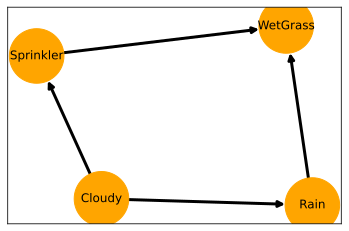

In [4]:
bn = BayesianNetwork()
bn.add_nodes(["Cloudy", "Sprinkler", "Rain", "WetGrass"])
bn.add_edges([("Cloudy", "Sprinkler"), ("Cloudy", "Rain"), ("Sprinkler", "WetGrass"), ("Rain", "WetGrass")])
bn.draw()

## Populate Bayesian Network with data

In [5]:
# Add data for node cloudy
data = {"Cloudy": [0,1], "Prob": [0.5,0.5]}
bn.add_node_pt("Cloudy", pd.DataFrame(data))

# Add data for node Sprinkler
data = {"Cloudy": [0,0,1,1], "Sprinkler": [0,1,0,1], "Prob": [0.5,0.5,0.9,0.1]}
bn.add_node_pt("Sprinkler", pd.DataFrame(data))

# Add data for node Cloudy
data = {"Cloudy": [0,0,1,1], "Rain": [0,1,0,1], "Prob": [0.8,0.2,0.2,0.8]}
bn.add_node_pt("Rain", pd.DataFrame(data))

# Add data for node WetGrass
data = {"Sprinkler": [0,0,0,0,1,1,1,1], "Rain": [0,0,1,1,0,0,1,1], "WetGrass": [0,1,0,1,0,1,0,1], "Prob": [1,0,0.1,0.9,0.1,0.9,0.01,0.99]}
bn.add_node_pt("WetGrass", pd.DataFrame(data))

## Apply sampling and get results

In [6]:
bn.direct_sampling(1000)

Sampling: 100%|██████████| 1000/1000 [00:03<00:00, 297.02it/s]


Prob
Cloudy Sprinkler Rain WetGrass       
1      0         1    1         0.319
0      0         0    0         0.199
       1         0    1         0.163
1      0         0    0         0.110
0      1         1    1         0.049
       0         1    1         0.047
1      0         1    0         0.038
       1         1    1         0.036
0      1         0    0         0.022
1      1         0    1         0.008
0      0         1    0         0.008
1      1         0    0         0.001